# Thicket and Extra-P: Thicket Tutorial

Thicket is a python-based toolkit for Exploratory Data Analysis (EDA) of parallel performance data that enables performance optimization and understanding of applications’ performance on supercomputers. It bridges the performance tool gap between being able to consider only a single instance of a simulation run (e.g., single platform, single measurement tool, or single scale) and finding actionable insights in multi-dimensional, multi-scale, multi-architecture, and multi-tool performance datasets.

#### NOTE: An interactive version of this notebook is available in the Binder environment.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/llnl/thicket-tutorial/develop)

# Thicket Modeling Example

This notebook provides an example for using Thicket's modeling feature. The modeling capability relies on _Extra-P_ - a tool for empirical performance modeling. It can perform N-parameter modeling with up to 3 parameters (N <= 3). The models follow a so-called _Performance Model Normal Form (PMNF)_ that expresses models as a summation of polynomial and logarithmic terms. One of the biggest advantages of this modeling method is that the produced models are human-readable and easily understandable.

***

## 1. Import Necessary Packages

To explore the capabilities of thicket with Extra-P, we begin by importing necessary packages.

In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from IPython.display import HTML

import thicket as th
from thicket.model_extrap import ExtrapInterface

display(HTML("<style>.container { width:80% !important; }</style>"))

<IPython.core.display.Javascript object>

## 2. Define Dataset Paths and Names

In this example, we use an MPI scaling study, profiled with Caliper, that has metadata about the runs. The data is also already aggregated, which means we can provide the data to Extra-P as-is.

In [2]:
data = "../data/lulesh/"
thicket = th.Thicket.from_caliperreader(data)

Specifically, the metadata table for this set of profiles contains a `jobsize` column, which provides the amount of cores used for each profile.

In [3]:
thicket.metadata

,cali.caliper.version,mpi.world.size,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,...,problem_size,num_regions,region_cost,region_balance,Compiler Name,Compiler Version,Built by,Compiler Flags,elapsed_time,figure_of_merit
profile,,,,,,,,,,,,,,,,,,,,,
9769411,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043783,...,30,11,1,1,GNU,10.3.1,ritter5,,178.482981,41282.322551
11813938,2.11.0-dev,216,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694046771,...,20,11,1,1,GNU,10.3.1,ritter5,,65.459871,112560.442119
23525129,2.11.0-dev,27,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694042822,...,50,11,1,1,GNU,10.3.1,ritter5,,961.691803,18887.807856
31414915,2.11.0-dev,125,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694044580,...,20,11,1,1,GNU,10.3.1,ritter5,,44.857425,78403.965497
44128685,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043936,...,40,11,1,1,GNU,10.3.1,ritter5,,569.652628,41366.065623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160038193,2.11.0-dev,125,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694044509,...,10,11,1,1,GNU,10.3.1,ritter5,,4.738553,43842.497474
4180439836,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043262,...,10,11,1,1,GNU,10.3.1,ritter5,,3.340089,24794.551813
4194772873,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043481,...,20,11,1,1,GNU,10.3.1,ritter5,,34.795095,40818.626358


## 3. More Information on a Function
***
You can use the `help()` method within Python to see the information for a given object. You can do this by typing `help(object)`. 
This will allow you to see the arguments for the function, and what will be returned. An example is below.

In [4]:
help(ExtrapInterface)

Help on class ExtrapInterface in module thicket.model_extrap:

class ExtrapInterface(builtins.object)
 |  ExtrapInterface() -> None
 |  
 |  A class that functions as an interface between Thicket and Extra-P 
 |  to load the data from a thicket into Extra-P, create performance models,
 |  append them to a thicket, and display the models.
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Create a new Extra-P Interface object.
 |  
 |  complexity_statsframe(self, columns: list[str] = None, eval_targets: list[list[float]] = None) -> None
 |      Analyzes the complexity of the Extra-P models for the given thicket statsframe and the list of selected columns (metrics) for a given target evaluation scale. Then adds the results back into the statsframe.
 |      
 |      Args:
 |          columns (list[str], optional): A list of columns (metrics) that should be considered. Defaults to None.
 |          eval_targets (list[list(float)], optional): A list of target scales (par

## 3. Create Models

First, we instatiate an Extra-P interface to create performance models and more.

In [5]:
extrap_interface = ExtrapInterface()

Then, we create the performance models by passing the thicket object that contains the performance measurements to the `create_models()` function of the `ExtrapInterface`. In order to create the models the interface requires some more information. First, we need to provide the names of the parameters that should be considered for modeling, e.g., the `jobsize`. The `create_models()` function will grab this column from the metadata table to use as our parameter. We also sub-select some metrics, since this dataset has a lot of metrics (otherwise the modeling will take a long time to do all metrics). Finally, we provide a name for the model configuration that the function is going to create for us. Extra-P will internally use the provided name as a unique identifier for modeling experiments. This will come in handy when experimenting with different modeling parameters, metrics, and modeler configurations.

In [6]:
extrap_interface.create_models(thicket, 
                               parameters=[
                                   "jobsize",
                                ], 
                               metrics=[
                                   "Avg time/rank (exc)",
                                   ],
                               model_name="config1")

/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$-1.039\times10^{−3}+4.453\times10^{−4}\cdot \log_2{p}^{1}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[


## 4. Models Dataframe

The created performance models including some statistical quality control metrics such as the RSS (residual sum of squares) or the SMAPE (symmetric mean absolute percentage error) are stored in thicket's aggregated statistics table.

In [7]:
thicket.statsframe.dataframe

,name,Avg time/rank (exc)_extrap-model,Avg time/rank (exc)_RSS_extrap-model,Avg time/rank (exc)_rRSS_extrap-model,Avg time/rank (exc)_SMAPE_extrap-model,Avg time/rank (exc)_AR2_extrap-model,Avg time/rank (exc)_RE_extrap-model
node,,,,,,,
"{'name': 'MPI_Barrier', 'type': 'function'}",MPI_Barrier,$-1.039\times10^{−3}+4.453\times10^{−4}\cdot \...,1.447227e-06,8.545707,48.405904,0.617853,0.685289
"{'name': 'MPI_Comm_dup', 'type': 'function'}",MPI_Comm_dup,$2.033\times10^{−5}+1.605\times10^{−7}\cdot p^...,5.055366e-08,8.842384,69.719797,-0.113187,0.837009
"{'name': 'MPI_Finalize', 'type': 'function'}",MPI_Finalize,$10^{−6}$,0.000000e+00,0.000000,0.000000,1.000000,0.000000
"{'name': 'MPI_Finalized', 'type': 'function'}",MPI_Finalized,$10^{−6}$,0.000000e+00,0.000000,0.000000,1.000000,0.000000
"{'name': 'MPI_Initialized', 'type': 'function'}",MPI_Initialized,$1.833\times10^{−6}$,8.333333e-13,0.729167,17.050298,1.000000,0.833333
"{'name': 'main', 'type': 'function'}",main,$8.209\times10^{−3}+3.719\times10^{−4}\cdot \l...,6.126005e-07,0.006114,3.256699,0.743588,0.027427
"{'name': 'CommRecv', 'type': 'function'}",CommRecv,$-9.937\times10^{−3}+7.143\times10^{−3}\cdot p...,3.033116e-06,0.007269,3.287004,0.995762,0.027221
"{'name': 'MPI_Irecv', 'type': 'function'}",MPI_Irecv,$-1.201\times10^{−2}+8.223\times10^{−3}\cdot p...,1.678652e-06,0.003539,2.657153,0.998228,0.021927
"{'name': 'CommSBN', 'type': 'function'}",CommSBN,$1.236\times10^{−3}+3.694\times10^{−4}\cdot p^...,4.971435e-07,0.014465,3.581461,0.997715,0.030795


## 5. Show the Models Dataframe with Embedded Plots

(For every `node`, sub-selected `metric` combination)

Besides the thicket object containing the models one can provide a variety of plotting options to the `to_html()` function that will change the displayed plots. One can for example select between displaying the mean, median, min, max measured metric values. Furthermore, one can display statistical values such as the RSS and SMAPE.

,Avg time/rank (exc)_extrap-model
node,
"{'name': 'MPI_Barrier', 'type': 'function'}",
"{'name': 'MPI_Comm_dup', 'type': 'function'}",
"{'name': 'MPI_Finalize', 'type': 'function'}",
"{'name': 'MPI_Finalized', 'type': 'function'}",
"{'name': 'MPI_Initialized', 'type': 'function'}",
"{'name': 'main', 'type': 'function'}",
"{'name': 'CommRecv', 'type': 'function'}",
"{'name': 'MPI_Irecv', 'type': 'function'}",
"{'name': 'CommSBN', 'type': 'function'}",

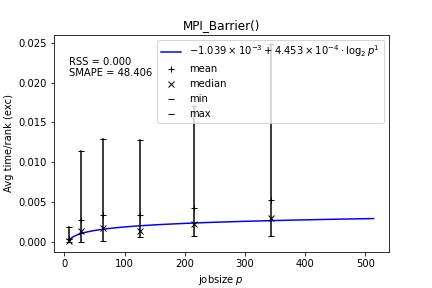
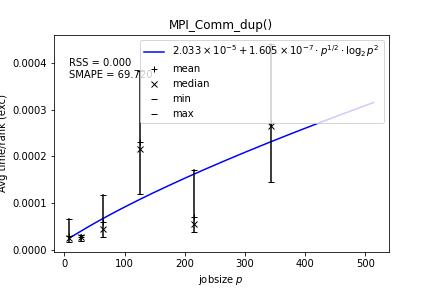
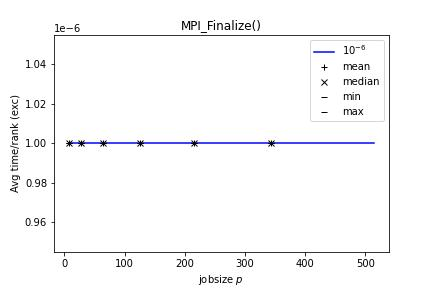
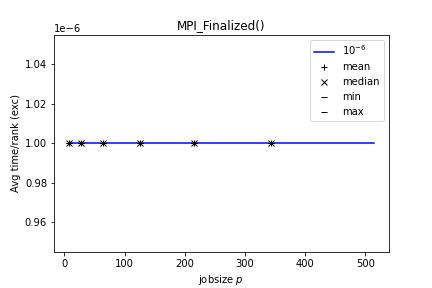
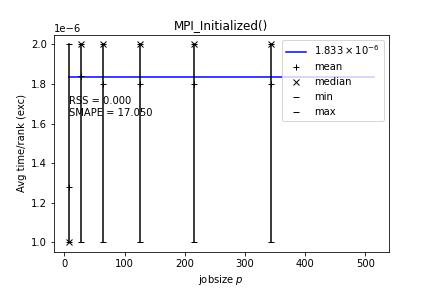
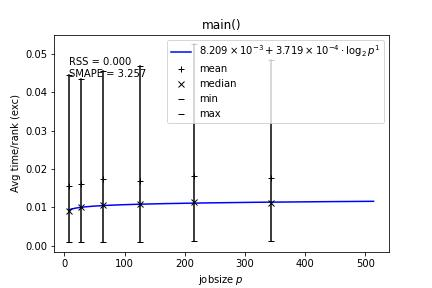
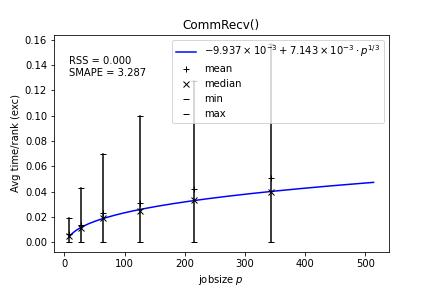
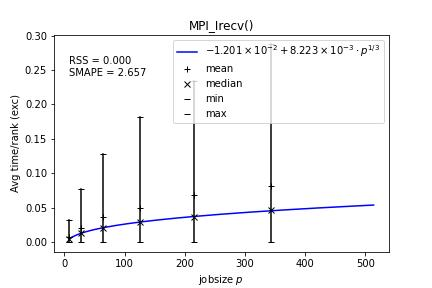
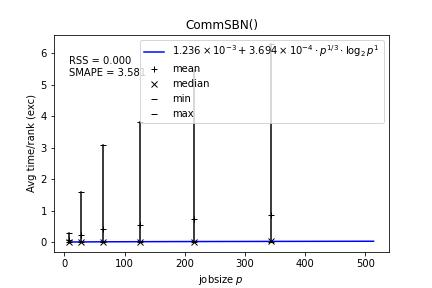
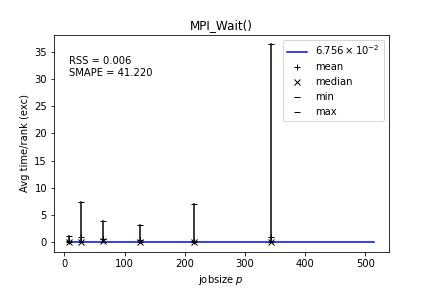
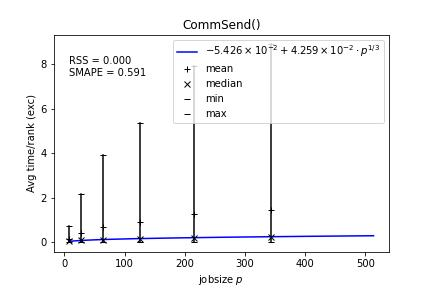
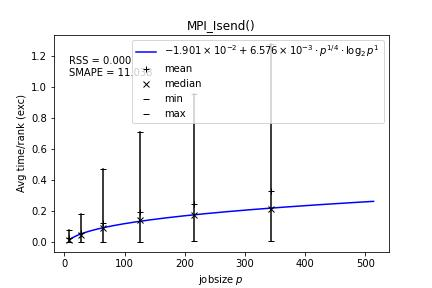
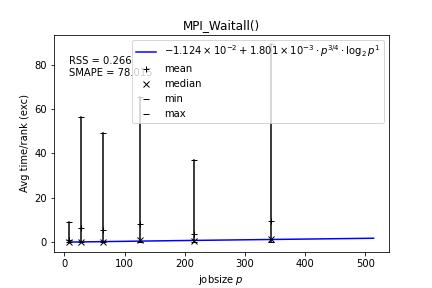
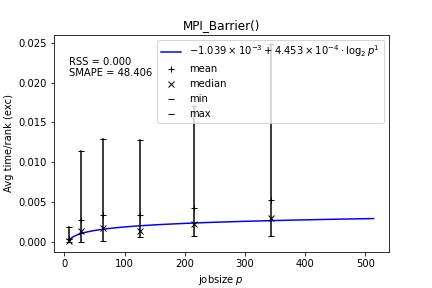
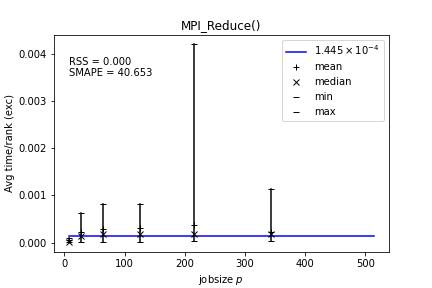
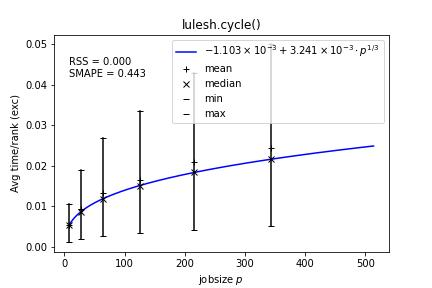
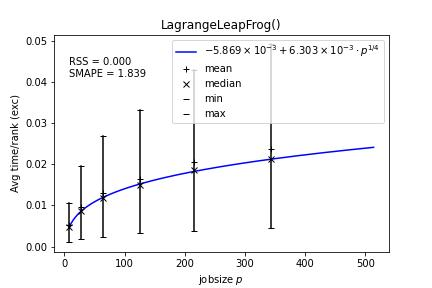
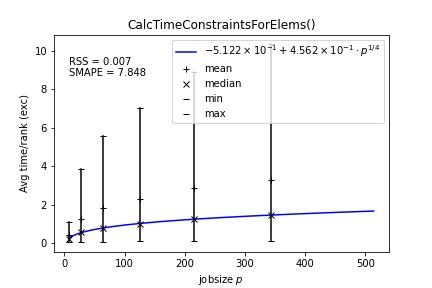
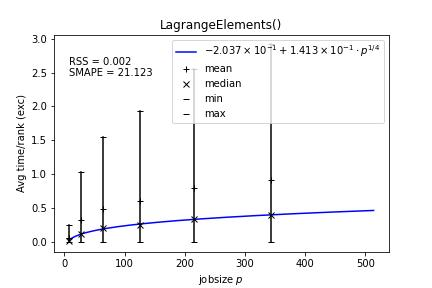
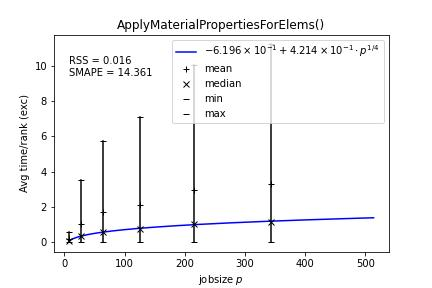
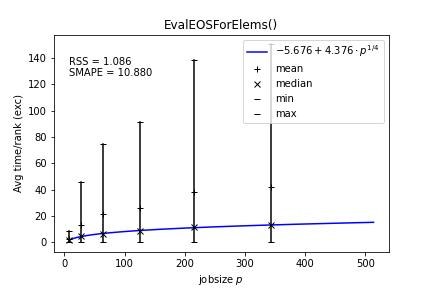
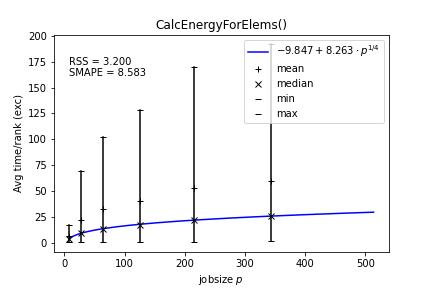
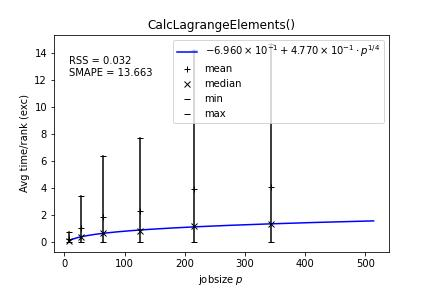
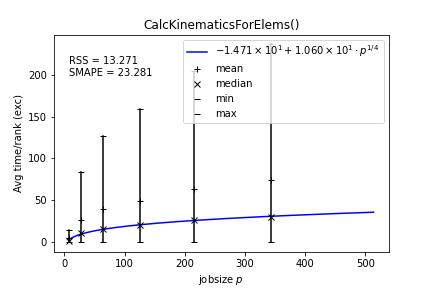
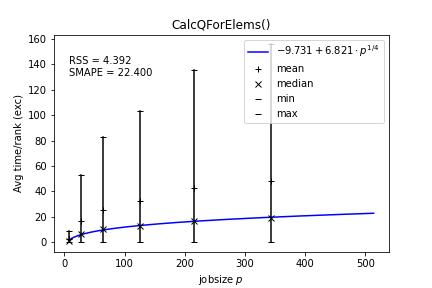
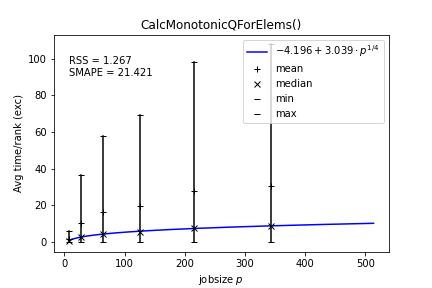
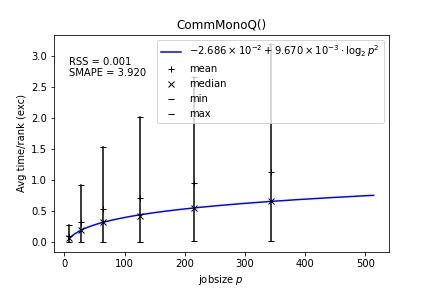
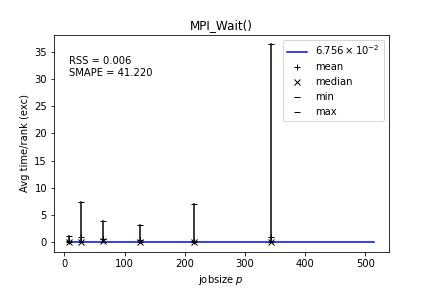
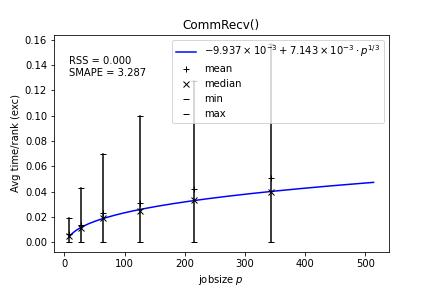
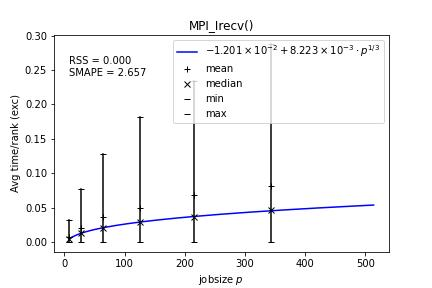
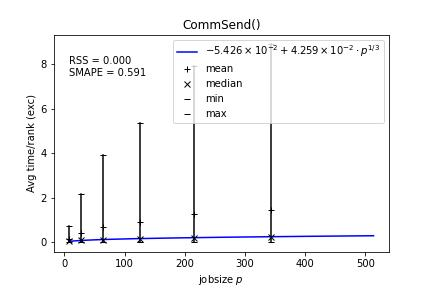
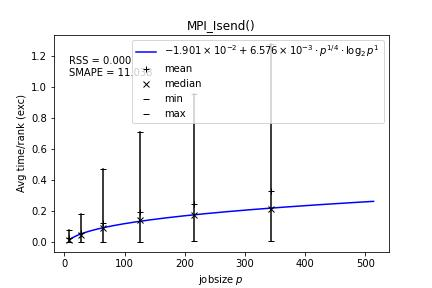
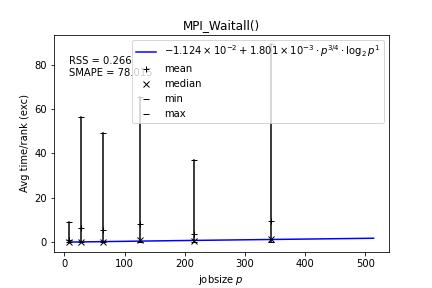
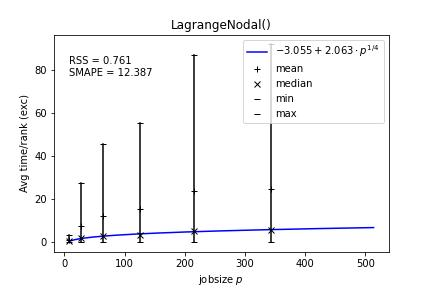
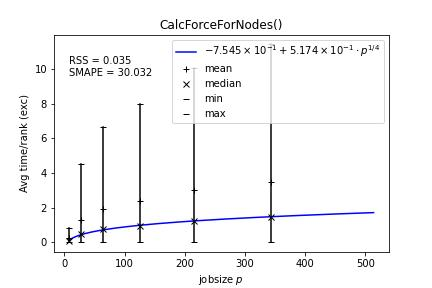
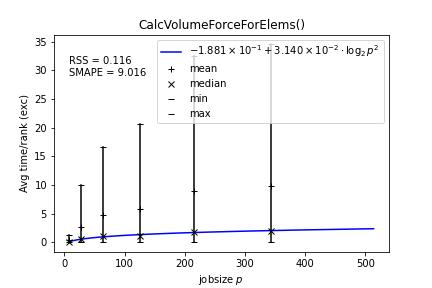
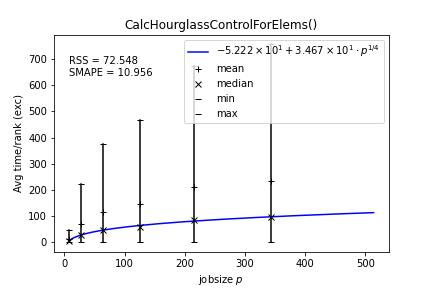
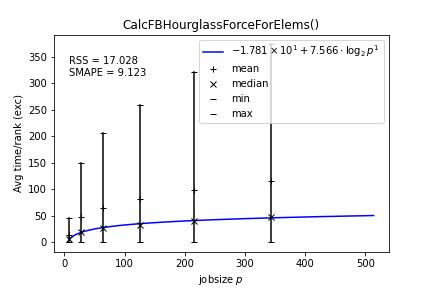
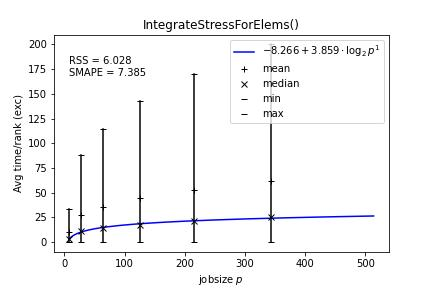
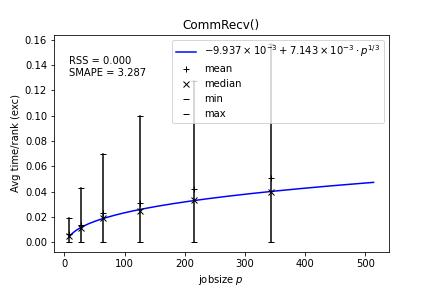
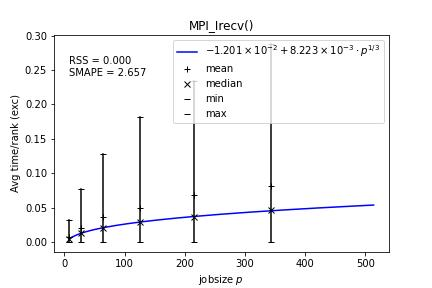
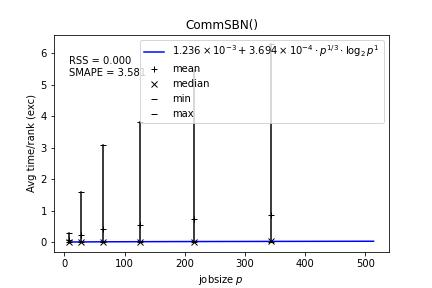
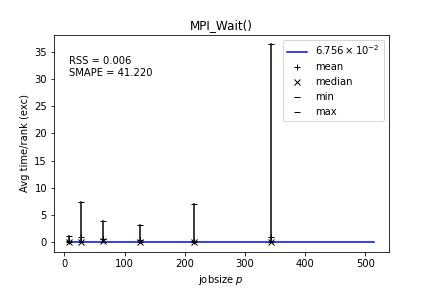
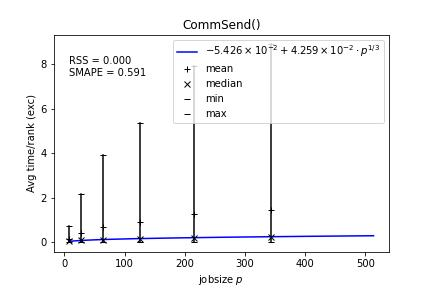
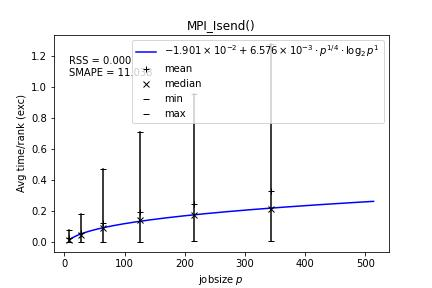
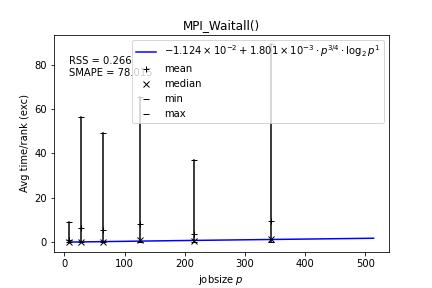
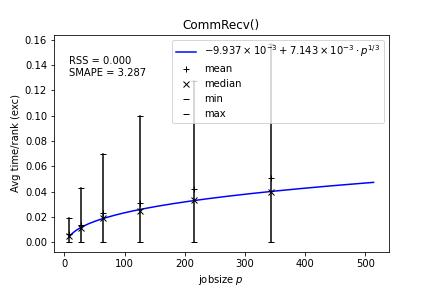
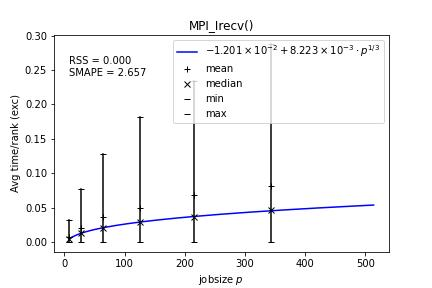
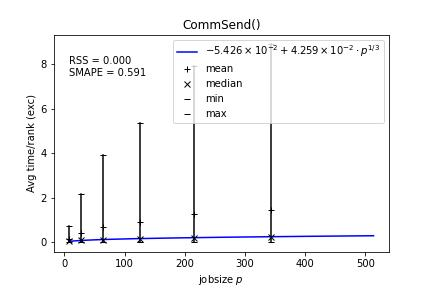
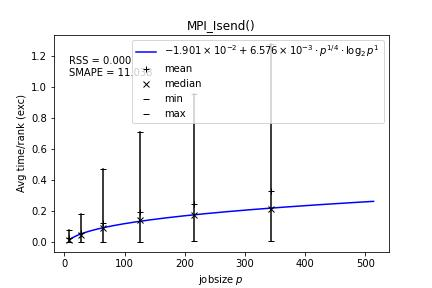
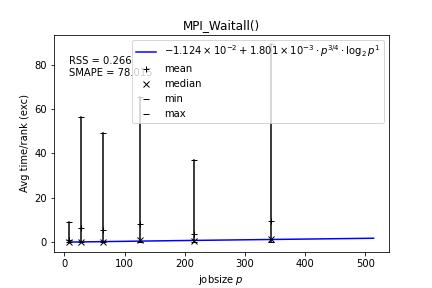
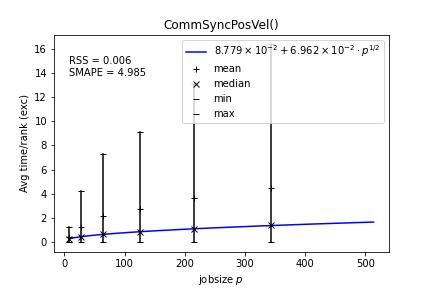
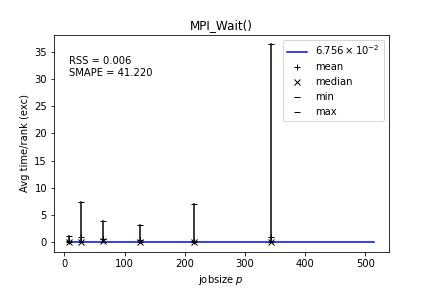
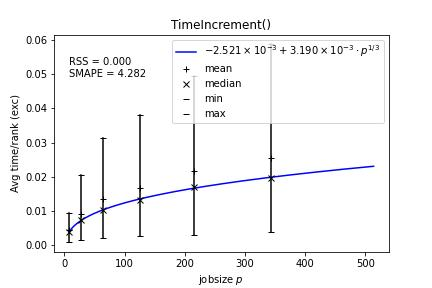
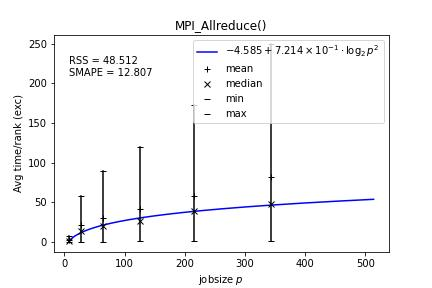

In [8]:
with pd.option_context("display.max_colwidth", 1):
    display(HTML(extrap_interface.to_html(thicket, show_mean=True, show_median=True, show_min_max=True, RSS=True, SMAPE=True)))

## 6. Query Specific Model

The last node `{"name": "MPI_Allreduce", "type": "function"}`, has an interesting graph so we want to retrieve its model. This can be achieved by indexing the `models_df` DataFrame for our chosen node for the metric `Avg time/rank (exc)_extrap-model`.

In [15]:
model_obj = thicket.statsframe.dataframe.at[thicket.statsframe.dataframe.index[len(thicket.statsframe.dataframe.index)-1], "Avg time/rank (exc)_extrap-model"]

## 7. Operations on a model

To predict a metric value for a specific configuration of the chosen model parameters, we can evaluate the model like a function by simply providing the values of the chosen parameters.

In [16]:
model_obj.eval(600)

56.85626730517517

### Displaying the model:

It returns a _figure_ and an _axis_ objects. The axis object can be used to adjust the plot, i.e., change labels. The `display()` function features several optional input variables that change they way how the data is displayed. For example we can set the `RSS` (bool) value, that determines whether to display Extra-P RSS on the plot. Furthermore, we can show the min, max, mean, and median measured metric values again. Finally, we have the option to display an "optimal" scaling model. If one has an idea how the function should scale like, this expectation function can be enetered as shown in the example code below. The plot then shows the expected metric value compared to the created Extra-P model, ready for comparison.

<Figure size 432x288 with 0 Axes>

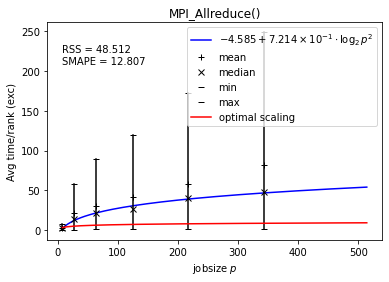

In [27]:
plt.clf()
fig, ax = model_obj.display(show_mean=True, show_median=True, 
                            show_min_max=True, 
                            RSS=True, SMAPE=True, show_opt_scaling=True,
                            opt_scaling_func="log2(p)**1")
plt.show()
plt.close()

## 8. Weak and strong scaling support

Extra-P can model measurement data from weak and strong scaling experiments. The examples shown in the previous cells all used weak scaling. To create a model using data from a strong scaling experiment, Extra-P uses a workaround. Essentially it converts the data from the strong scaling experiment to a weak scaling experiment. As a consequence metric values, e.g., the runtime increases the larger the jobsize. This might me confusing at first as one would expect the runtime to decrease the larger the jobsize. When analyzing the scalability of the created models one has to think of it as a weak scaling experiment instead of strong scaling.

In [33]:
data_strong = "../data/lulesh_strong"
thicket_strong = th.Thicket.from_caliperreader(data_strong)
extrap_interface_strong = ExtrapInterface()

### Creating models for strong scaling measurements:

To use this functionality we simply have to set the variable `calc_total_metrics=True` of the `create_models()` function. In addition we need to specify the scaling parameter of the performance experiment, which is usually the resource allocation, e.g., the number of MPI ranks. In this example the *jobsize* corresponds to the number of MPI ranks the application was executed with. Therefore, we set `scaling_parameter="jobsize"` accordingly. Based on this information Extra-P multiplies the measured metric values with the number of MPI ranks, to convert the data from a weak into a strong scaling experiment. Though, this is only done for metrics that are measured per rank, e.g., the *Avg time/rank*. This conversion does not apply to metrics such as the *Total time* for which it would make no sense. If the `scaling` and `scaling_parameter` parameters of the `create_models()` function are not specified, the data will be automatically read as a weak scaling experiment.

In [36]:
extrap_interface_strong.create_models(thicket_strong, 
                                parameters=[
                                   "jobsize",
                                ], 
                               metrics=[
                                   "Avg time/rank",
                                   "Total time"
                                   ],
                               use_median=True,
                               calc_total_metrics=True,
                               scaling_parameter="jobsize",
                               model_name="config1")

ERROR: A configuration with the name 'config1' already exists. Choose another name!


### Analyzing a strong scaling experiment

Subesequently, we can analyze the data as before. We can take a look at thicket's aggregated statistics table or show the models dataframe with the embedded plots.

In [37]:
thicket_strong.statsframe.dataframe

,name,Total time_extrap-model,Total time_RSS_extrap-model,Total time_rRSS_extrap-model,Total time_SMAPE_extrap-model,Total time_AR2_extrap-model,Total time_RE_extrap-model,Avg time/rank_extrap-model,Avg time/rank_RSS_extrap-model,Avg time/rank_rRSS_extrap-model,Avg time/rank_SMAPE_extrap-model,Avg time/rank_AR2_extrap-model,Avg time/rank_RE_extrap-model
node,,,,,,,,,,,,,
"{'name': 'main', 'type': 'function'}",main,$-5.618\times10^{2}+4.866\times10^{2}\cdot p^{...,108127.505764,0.197867,18.063055,0.884946,0.153026,$-5.618\times10^{2}+4.866\times10^{2}\cdot p^{...,108127.513302,0.197867,18.063053,0.884946,0.153026
"{'name': 'CommRecv', 'type': 'function'}",CommRecv,$2.426\times10^{−2}+3.960\times10^{−4}\cdot p^...,0.012974,0.105542,13.101269,0.988287,0.104551,$2.426\times10^{−2}+3.960\times10^{−4}\cdot p^...,0.012960,0.105481,13.097851,0.988300,0.104523
"{'name': 'CommSBN', 'type': 'function'}",CommSBN,$6.146$,205.586658,7.804934,64.502937,1.000000,2.096066,$6.146$,205.586865,7.805010,64.503092,1.000000,2.096031
"{'name': 'CommSend', 'type': 'function'}",CommSend,$7.370\times10^{−1}+1.640\times10^{−2}\cdot p^...,15.172917,0.182109,19.693681,0.943755,0.165484,$7.370\times10^{−1}+1.640\times10^{−2}\cdot p^...,15.172398,0.182106,19.693291,0.943757,0.165481
"{'name': 'lulesh.cycle', 'type': 'function'}",lulesh.cycle,$-5.595\times10^{2}+4.855\times10^{2}\cdot p^{...,107917.130062,0.201398,18.124851,0.884649,0.153769,$-5.595\times10^{2}+4.855\times10^{2}\cdot p^{...,107917.105773,0.201398,18.124848,0.884649,0.153769
"{'name': 'LagrangeLeapFrog', 'type': 'function'}",LagrangeLeapFrog,$-2.583\times10^{2}+1.563\times10^{2}\cdot \lo...,118424.336814,0.156942,18.291172,0.729735,0.148258,$-2.583\times10^{2}+1.563\times10^{2}\cdot \lo...,118424.279056,0.156942,18.291172,0.729735,0.148258
"{'name': 'CalcTimeConstraintsForElems', 'type': 'function'}",CalcTimeConstraintsForElems,$1.382+4.864\times10^{−2}\cdot p^{3/4}\cdot \l...,7.413584,0.082882,10.667008,0.987705,0.090966,$1.382+4.864\times10^{−2}\cdot p^{3/4}\cdot \l...,7.413757,0.082891,10.667412,0.987705,0.090971
"{'name': 'LagrangeElements', 'type': 'function'}",LagrangeElements,$-1.231\times10^{1}+1.790\times10^{1}\cdot p^{...,28904.303367,0.171095,18.997782,0.842693,0.150553,$-1.231\times10^{1}+1.790\times10^{1}\cdot p^{...,28904.271782,0.171095,18.997777,0.842693,0.150553
"{'name': 'ApplyMaterialPropertiesForElems', 'type': 'function'}",ApplyMaterialPropertiesForElems,$1.497\times10^{1}+5.970\cdot p^{3/4}$,5322.410114,0.090452,12.408118,0.954521,0.098806,$1.497\times10^{1}+5.970\cdot p^{3/4}$,5322.415026,0.090452,12.408115,0.954521,0.098806


When analyzing the models dataframe with the embedded plots, we see that models for the metrics *Avg time/rank, Total time*. are almost perfectly identical. This should be the case and indicates that the strong scaling data was correctly converted into a weak scaling experiment.

In this case both metrics are showing redundant information as we intentionally measured the total time to highlight the conversion process. In reality the *Total time* might not be available as a metric. 

Subsequently, one can analyze and display the created models as before.

<Figure size 432x288 with 0 Axes>

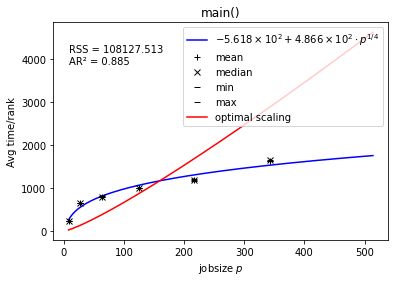

In [45]:
model_obj = thicket_strong.statsframe.dataframe.at[thicket_strong.statsframe.dataframe.index[0], "Avg time/rank_extrap-model"]
plt.clf()
fig, ax = model_obj.display(show_mean=True, show_median=True, 
                            show_min_max=True, RSS=True, 
                            AR2=True, show_opt_scaling=True,
                            opt_scaling_func="p**1*log2(p)**1")
ax.legend(loc=1)
plt.show()
plt.close()